# 1. Data preprocessing

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re

In [2]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

# Train dev split
df1_train, df1_dev = train_test_split(df1, stratify=df1['label'], random_state=42)
df2_train, df2_dev = train_test_split(df2, stratify=df2['label'], random_state=42)

# Join data in both domains for trating them jointly (Augmentation)
dev_set = pd.concat([df1_dev, df2_dev]).reset_index(drop=True)
df3_train = pd.concat([df1_train, df2_train]).reset_index(drop=True)

# Train and dev sets
x_tr, y_train = [re.sub(',', '', ', '.join([str(x) for x in tok])) for tok in df3_train['text']], df3_train['label']
x_dev, y_dev = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in dev_set['text']], dev_set['label']

# 2. Encoding

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Cvec encoding
Cvec = CountVectorizer()
x_train = Cvec.fit_transform(x_tr)
x_dev = Cvec.transform(x_dev)

# # Tvec encoding
# Tvec = TfidfVectorizer(ngram_range=(1, 2))
# x_train = Tvec.fit_transform(x_tr)
# x_dev = Tvec.transform(x_dev)

# 3 DL Models (Embeding model)

In [4]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
device = 'cpu'
torch.manual_seed(42)

In [5]:
# Weights function
def weights(df):
    w = list(len(df['label'])/df['label'].value_counts())
    sample_weights = [0] * df.shape[0]
    for idx, label in enumerate(df['label']):
        sample_weights[idx] = w[label]
    return sample_weights

# Dataset to TensorDataset
train_DS = TensorDataset(torch.from_numpy(x_train.todense()).float(), torch.from_numpy(np.array(y_train)).float().reshape(-1,1))
dev_DS = TensorDataset(torch.from_numpy(x_dev.todense()).float(), torch.from_numpy(np.array(y_dev)).float().reshape(-1,1))

# Sample data
sampler_tr = torch.utils.data.WeightedRandomSampler(weights(df3_train), num_samples=len(train_DS), replacement=True)
sampler_ts = torch.utils.data.WeightedRandomSampler(weights(dev_set), num_samples=len(dev_DS), replacement=True)

# Create dataloaders
bs = 32
x_tr_dl = DataLoader(train_DS, batch_size=bs, sampler=sampler_tr)
x_dev_dl = DataLoader(dev_DS, batch_size=bs, sampler=sampler_ts)

: 

: 

In [ ]:
from torch import nn
class BowNetwork(nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super().__init__()
        self.first_layer = nn.Linear(vocab_size, hidden_dim) 
        nn.init.uniform_(self.first_layer.weight)
        self.second_layer = nn.Linear(hidden_dim, hidden_dim)
        self.third_layer = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.dropout(x)
        x = torch.relu(self.first_layer(x)) 
        x = torch.relu(self.second_layer(x))
        logits = self.third_layer(x)
        return logits

In [1]:
vocab_size = x_train.shape[1]
bow_model = BowNetwork(vocab_size, 100).to(device)
print(bow_model)

NameError: name 'x_train' is not defined

In [100]:
# Loss fn
loss_fn = nn.BCEWithLogitsLoss()
# Optimizer
optimizer = torch.optim.Adam(bow_model.parameters())

In [101]:
from tqdm import tqdm
# Train
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, acc, total = 0, 0, 0
    for X, y in tqdm(dataloader):
        pred = model(X)                         # Forward pass
        loss = loss_fn(pred, y)                 # Compute loss 
        loss.backward()                         # Backpropagation
        optimizer.step()                        # Update parameters
        optimizer.zero_grad()                   # Reset gradient
    
        # Metrics
        train_loss += loss.item()
        total += len(y)
        result = (pred>0.5).float()
        acc += (result == y).sum().item()
        
    # General metrics
    train_loss /= total
    acc /= size
    return train_loss, acc

In [102]:
# Test
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, acc, total = 0, 0, 0
    with torch.no_grad():       # Specify no gradient
        for X, y in dataloader:
            pred = model(X)                                     # Forward pass
            test_loss += loss_fn(pred, y).item()  # Compute loss     
            
            # Metrics
            result = (pred>0.5).float()             # Results to binary
            acc += (result == y).sum().item()       # Accuracy
            total += len(y)                         # Total observations
            
    # General metrics
    test_loss /= total
    acc /= size
    return test_loss, acc

In [103]:
from tqdm import tqdm, tqdm_notebook # show progress bar

# Epochs
epochs = 100
train_loss, valid_loss = [], []
print("Training BOW feedforward network model!")
for t in range(epochs):
    tl, train_acc = train(x_tr_dl, bow_model, optimizer)
    vl, valid_acc = test(x_dev_dl, bow_model)
    # Losses to dict
    train_loss.append(tl)
    valid_loss.append(vl)
    # Print results
    tqdm.write(
        f'epoch #{t}\ttrain_acc: {train_acc:.3f}\tvalid_acc: {valid_acc:.3f}',
    )

Training BOW feedforward network model!


100%|██████████| 422/422 [00:11<00:00, 35.41it/s]


epoch #0	train_acc: 0.646	valid_acc: 0.723


100%|██████████| 422/422 [00:11<00:00, 35.59it/s]


epoch #1	train_acc: 0.782	valid_acc: 0.726


100%|██████████| 422/422 [00:11<00:00, 35.26it/s]


epoch #2	train_acc: 0.850	valid_acc: 0.803


100%|██████████| 422/422 [00:11<00:00, 36.04it/s]


epoch #3	train_acc: 0.899	valid_acc: 0.809


100%|██████████| 422/422 [00:11<00:00, 35.87it/s]


epoch #4	train_acc: 0.919	valid_acc: 0.776


100%|██████████| 422/422 [00:11<00:00, 35.47it/s]


epoch #5	train_acc: 0.948	valid_acc: 0.553


100%|██████████| 422/422 [00:12<00:00, 35.16it/s]


epoch #6	train_acc: 0.954	valid_acc: 0.798


100%|██████████| 422/422 [00:12<00:00, 34.66it/s]


epoch #7	train_acc: 0.959	valid_acc: 0.772


100%|██████████| 422/422 [00:12<00:00, 34.41it/s]


epoch #8	train_acc: 0.965	valid_acc: 0.704


100%|██████████| 422/422 [00:11<00:00, 36.84it/s]


epoch #9	train_acc: 0.965	valid_acc: 0.800


100%|██████████| 422/422 [00:11<00:00, 37.49it/s]


epoch #10	train_acc: 0.973	valid_acc: 0.799


100%|██████████| 422/422 [00:11<00:00, 36.53it/s]


epoch #11	train_acc: 0.965	valid_acc: 0.689


100%|██████████| 422/422 [00:11<00:00, 37.07it/s]


epoch #12	train_acc: 0.979	valid_acc: 0.745


100%|██████████| 422/422 [00:11<00:00, 36.03it/s]


epoch #13	train_acc: 0.981	valid_acc: 0.781


100%|██████████| 422/422 [00:12<00:00, 34.15it/s]


epoch #14	train_acc: 0.980	valid_acc: 0.831


100%|██████████| 422/422 [00:12<00:00, 34.76it/s]


epoch #15	train_acc: 0.983	valid_acc: 0.711


100%|██████████| 422/422 [00:11<00:00, 35.50it/s]


epoch #16	train_acc: 0.980	valid_acc: 0.840


100%|██████████| 422/422 [00:12<00:00, 35.15it/s]


epoch #17	train_acc: 0.988	valid_acc: 0.729


100%|██████████| 422/422 [00:11<00:00, 35.82it/s]


epoch #18	train_acc: 0.984	valid_acc: 0.751


100%|██████████| 422/422 [00:12<00:00, 34.17it/s]


epoch #19	train_acc: 0.991	valid_acc: 0.767


100%|██████████| 422/422 [00:12<00:00, 34.67it/s]


epoch #20	train_acc: 0.987	valid_acc: 0.829


100%|██████████| 422/422 [00:12<00:00, 34.72it/s]


epoch #21	train_acc: 0.989	valid_acc: 0.739


100%|██████████| 422/422 [00:12<00:00, 34.39it/s]


epoch #22	train_acc: 0.992	valid_acc: 0.767


100%|██████████| 422/422 [00:12<00:00, 32.78it/s]


epoch #23	train_acc: 0.982	valid_acc: 0.724


100%|██████████| 422/422 [00:13<00:00, 32.27it/s]


epoch #24	train_acc: 0.990	valid_acc: 0.652


100%|██████████| 422/422 [00:15<00:00, 28.08it/s]


epoch #25	train_acc: 0.988	valid_acc: 0.743


100%|██████████| 422/422 [00:18<00:00, 22.57it/s]


epoch #26	train_acc: 0.992	valid_acc: 0.737


100%|██████████| 422/422 [00:19<00:00, 21.69it/s]


epoch #27	train_acc: 0.986	valid_acc: 0.716


100%|██████████| 422/422 [00:17<00:00, 24.35it/s]


epoch #28	train_acc: 0.989	valid_acc: 0.750


100%|██████████| 422/422 [00:14<00:00, 28.54it/s]


epoch #29	train_acc: 0.993	valid_acc: 0.814


100%|██████████| 422/422 [00:14<00:00, 29.70it/s]


epoch #30	train_acc: 0.992	valid_acc: 0.783


100%|██████████| 422/422 [00:14<00:00, 29.54it/s]


epoch #31	train_acc: 0.995	valid_acc: 0.663


100%|██████████| 422/422 [00:13<00:00, 30.59it/s]


epoch #32	train_acc: 0.994	valid_acc: 0.686


100%|██████████| 422/422 [00:13<00:00, 31.31it/s]


epoch #33	train_acc: 0.990	valid_acc: 0.757


100%|██████████| 422/422 [00:13<00:00, 31.38it/s]


epoch #34	train_acc: 0.995	valid_acc: 0.819


100%|██████████| 422/422 [00:13<00:00, 30.74it/s]


epoch #35	train_acc: 0.991	valid_acc: 0.798


100%|██████████| 422/422 [00:13<00:00, 31.25it/s]


epoch #36	train_acc: 0.996	valid_acc: 0.694


100%|██████████| 422/422 [00:13<00:00, 30.58it/s]


epoch #37	train_acc: 0.991	valid_acc: 0.779


100%|██████████| 422/422 [00:13<00:00, 30.94it/s]


epoch #38	train_acc: 0.994	valid_acc: 0.830


100%|██████████| 422/422 [00:13<00:00, 30.97it/s]


epoch #39	train_acc: 0.994	valid_acc: 0.753


100%|██████████| 422/422 [00:13<00:00, 30.56it/s]


epoch #40	train_acc: 0.985	valid_acc: 0.737


100%|██████████| 422/422 [00:13<00:00, 31.04it/s]


epoch #41	train_acc: 0.995	valid_acc: 0.804


100%|██████████| 422/422 [00:13<00:00, 30.57it/s]


epoch #42	train_acc: 0.996	valid_acc: 0.730


100%|██████████| 422/422 [00:12<00:00, 32.63it/s]


epoch #43	train_acc: 0.995	valid_acc: 0.774


100%|██████████| 422/422 [00:13<00:00, 30.65it/s]


epoch #44	train_acc: 0.993	valid_acc: 0.779


100%|██████████| 422/422 [00:14<00:00, 30.03it/s]


epoch #45	train_acc: 0.988	valid_acc: 0.751


100%|██████████| 422/422 [00:13<00:00, 31.81it/s]


epoch #46	train_acc: 0.997	valid_acc: 0.725


100%|██████████| 422/422 [00:13<00:00, 31.53it/s]


epoch #47	train_acc: 0.995	valid_acc: 0.754


100%|██████████| 422/422 [00:13<00:00, 31.25it/s]


epoch #48	train_acc: 0.994	valid_acc: 0.751


100%|██████████| 422/422 [00:13<00:00, 30.64it/s]


epoch #49	train_acc: 0.995	valid_acc: 0.750


100%|██████████| 422/422 [00:14<00:00, 28.46it/s]


epoch #50	train_acc: 0.995	valid_acc: 0.807


100%|██████████| 422/422 [00:14<00:00, 29.81it/s]


epoch #51	train_acc: 0.995	valid_acc: 0.705


100%|██████████| 422/422 [00:14<00:00, 28.97it/s]


epoch #52	train_acc: 0.997	valid_acc: 0.800


100%|██████████| 422/422 [00:13<00:00, 30.63it/s]


epoch #53	train_acc: 0.997	valid_acc: 0.747


100%|██████████| 422/422 [00:14<00:00, 29.79it/s]


epoch #54	train_acc: 0.994	valid_acc: 0.612


100%|██████████| 422/422 [00:14<00:00, 30.10it/s]


epoch #55	train_acc: 0.997	valid_acc: 0.749


100%|██████████| 422/422 [00:12<00:00, 32.70it/s]


epoch #56	train_acc: 0.996	valid_acc: 0.789


100%|██████████| 422/422 [00:13<00:00, 30.19it/s]


epoch #57	train_acc: 0.995	valid_acc: 0.805


100%|██████████| 422/422 [00:14<00:00, 29.46it/s]


epoch #58	train_acc: 0.997	valid_acc: 0.794


100%|██████████| 422/422 [00:14<00:00, 30.11it/s]


epoch #59	train_acc: 0.994	valid_acc: 0.769


100%|██████████| 422/422 [00:13<00:00, 31.07it/s]


epoch #60	train_acc: 0.996	valid_acc: 0.765


100%|██████████| 422/422 [00:12<00:00, 32.59it/s]


epoch #61	train_acc: 0.994	valid_acc: 0.832


100%|██████████| 422/422 [00:13<00:00, 31.33it/s]


epoch #62	train_acc: 0.994	valid_acc: 0.758


100%|██████████| 422/422 [00:13<00:00, 31.88it/s]


epoch #63	train_acc: 0.996	valid_acc: 0.769


100%|██████████| 422/422 [00:13<00:00, 32.35it/s]


epoch #64	train_acc: 0.995	valid_acc: 0.719


100%|██████████| 422/422 [00:13<00:00, 30.48it/s]


epoch #65	train_acc: 0.992	valid_acc: 0.716


100%|██████████| 422/422 [00:13<00:00, 30.18it/s]


epoch #66	train_acc: 0.997	valid_acc: 0.747


100%|██████████| 422/422 [00:13<00:00, 31.00it/s]


epoch #67	train_acc: 0.996	valid_acc: 0.782


100%|██████████| 422/422 [00:13<00:00, 31.92it/s]


epoch #68	train_acc: 0.996	valid_acc: 0.754


100%|██████████| 422/422 [00:13<00:00, 30.70it/s]


epoch #69	train_acc: 0.994	valid_acc: 0.772


100%|██████████| 422/422 [00:14<00:00, 30.08it/s]


epoch #70	train_acc: 0.997	valid_acc: 0.746


100%|██████████| 422/422 [00:13<00:00, 30.65it/s]


epoch #71	train_acc: 0.998	valid_acc: 0.727


100%|██████████| 422/422 [00:13<00:00, 31.48it/s]


epoch #72	train_acc: 0.998	valid_acc: 0.754


100%|██████████| 422/422 [00:12<00:00, 33.25it/s]


epoch #73	train_acc: 0.998	valid_acc: 0.759


100%|██████████| 422/422 [00:13<00:00, 31.91it/s]


epoch #74	train_acc: 0.995	valid_acc: 0.809


100%|██████████| 422/422 [00:13<00:00, 30.78it/s]


epoch #75	train_acc: 0.997	valid_acc: 0.719


100%|██████████| 422/422 [00:14<00:00, 29.99it/s]


epoch #76	train_acc: 0.997	valid_acc: 0.718


100%|██████████| 422/422 [00:13<00:00, 32.30it/s]


epoch #77	train_acc: 0.995	valid_acc: 0.730


100%|██████████| 422/422 [00:13<00:00, 31.19it/s]


epoch #78	train_acc: 0.997	valid_acc: 0.752


100%|██████████| 422/422 [00:13<00:00, 31.88it/s]


epoch #79	train_acc: 0.998	valid_acc: 0.794


100%|██████████| 422/422 [00:12<00:00, 32.83it/s]


epoch #80	train_acc: 0.995	valid_acc: 0.713


100%|██████████| 422/422 [00:12<00:00, 33.88it/s]


epoch #81	train_acc: 0.997	valid_acc: 0.725


100%|██████████| 422/422 [00:13<00:00, 32.32it/s]


epoch #82	train_acc: 0.997	valid_acc: 0.829


100%|██████████| 422/422 [00:12<00:00, 32.63it/s]


epoch #83	train_acc: 0.997	valid_acc: 0.787


100%|██████████| 422/422 [00:13<00:00, 32.12it/s]


epoch #84	train_acc: 0.996	valid_acc: 0.698


100%|██████████| 422/422 [00:13<00:00, 32.19it/s]


epoch #85	train_acc: 0.994	valid_acc: 0.790


100%|██████████| 422/422 [00:12<00:00, 32.69it/s]


epoch #86	train_acc: 0.997	valid_acc: 0.741


100%|██████████| 422/422 [00:12<00:00, 33.11it/s]


epoch #87	train_acc: 0.998	valid_acc: 0.740


100%|██████████| 422/422 [00:12<00:00, 32.96it/s]


epoch #88	train_acc: 0.997	valid_acc: 0.684


100%|██████████| 422/422 [00:13<00:00, 31.27it/s]


epoch #89	train_acc: 0.996	valid_acc: 0.781


100%|██████████| 422/422 [00:12<00:00, 32.56it/s]


epoch #90	train_acc: 0.995	valid_acc: 0.798


100%|██████████| 422/422 [00:13<00:00, 32.44it/s]


epoch #91	train_acc: 0.996	valid_acc: 0.809


100%|██████████| 422/422 [00:13<00:00, 30.97it/s]


epoch #92	train_acc: 0.997	valid_acc: 0.666


100%|██████████| 422/422 [00:12<00:00, 33.25it/s]


epoch #93	train_acc: 0.996	valid_acc: 0.773


100%|██████████| 422/422 [00:13<00:00, 32.12it/s]


epoch #94	train_acc: 0.997	valid_acc: 0.768


100%|██████████| 422/422 [00:13<00:00, 31.74it/s]


epoch #95	train_acc: 0.998	valid_acc: 0.740


100%|██████████| 422/422 [00:13<00:00, 32.07it/s]


epoch #96	train_acc: 0.997	valid_acc: 0.772


100%|██████████| 422/422 [00:13<00:00, 31.79it/s]


epoch #97	train_acc: 0.996	valid_acc: 0.761


100%|██████████| 422/422 [00:13<00:00, 31.13it/s]


epoch #98	train_acc: 0.997	valid_acc: 0.741


100%|██████████| 422/422 [00:14<00:00, 30.09it/s]


epoch #99	train_acc: 0.995	valid_acc: 0.771


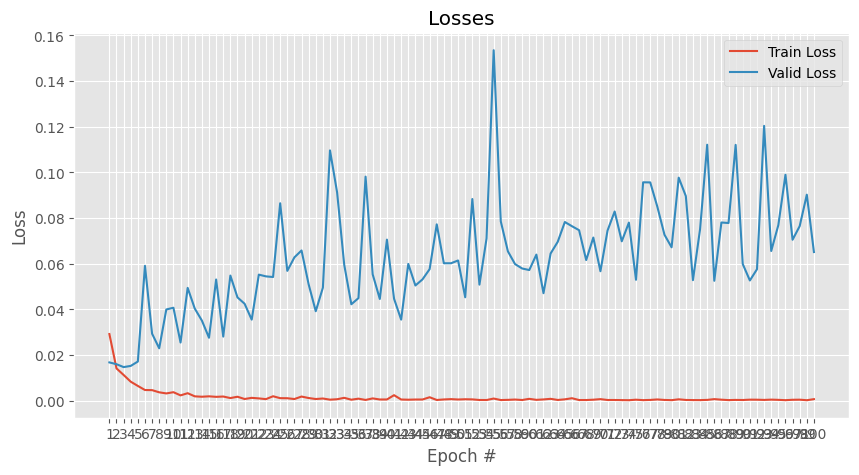

In [105]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
epoch_ticks = range(1, epochs + 1)
plt.plot(epoch_ticks, train_loss)
plt.plot(epoch_ticks, valid_loss)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

# Predict on sample data

In [13]:
# Predict on sample data
# Read data
test = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in pd.read_json('test_data.json', lines=True)['text']]
# Encoding
x_test = torch.from_numpy(Cvec.transform(test).todense()).float()
# Predict
x_pred = [int(i) for i in (bow_model(x_test)>0.5).float()]
# Create DF
df = pd.DataFrame([[i,j] for i,j in enumerate(x_pred)], columns=['id', 'class'])
# Save file
df.to_csv('predictions.csv', index=False)